# Denoised and Pick DAS

This notebook test the ensemble deep learning picker from Yuan et al, 2023 on DAS data, whether it is raw data or denoised using MAE.

Marine Denolle 
Qibin Shi

Import modules


This notebook assumes that your environment has:
seisbench
elep

Get it from there https://github.com/congcy/ELEP and install it

In [1]:
import sys
sys.path.append("../src/denoiser/")
sys.path.append("../src/ensemble_picker/")
sys.path.append("../models/")

import gc
import h5py
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader

# This package
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from das_util import try_gpu

# seisbench
import seisbench.models as sbm

# some ELEP functions
from mbf_elep_func import apply_mbf

In [2]:
from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

## Get the data

where is the data ?

In [14]:
! du -sh /fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023*

8.3G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_22.hdf5
3.8G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5
5.2G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_12.hdf5
5.4G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_16.hdf5
11G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5


### Prepare and read Data

In [3]:
sampling_rate = 25 # number of points per second
dchan = 10 # channel spacing in mebers
chan_max = 4500  # maximum channel to trim the data

In [4]:
### Read (change the file to the latest if needed)
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_07_29.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['quake'][:]
    
# combine both arrays
rawdata = np.append(quake2[:,:chan_max,:], quake1[:,:chan_max,:], axis=0)

In [5]:
print(rawdata.shape)
print(f'there are  {rawdata.shape[0]:d}  events, for {rawdata.shape[1]:d} channels, and {rawdata.shape[2]:d} samples in time')

(180, 4500, 1500)
there are  180  events, for 4500 channels, and 1500 samples in time


### Filter data & normalize

In [6]:
### Filter
b, a = butter(4, (0.5, 12), fs=sampling_rate, btype='bandpass')
filtered_data = filtfilt(b, a, rawdata, axis=2)
filtered_data_norm = filtered_data / np.std(filtered_data, axis=(1,2), keepdims=True)  ## standard scaling

Plot the data .  Take the example of the 5th event

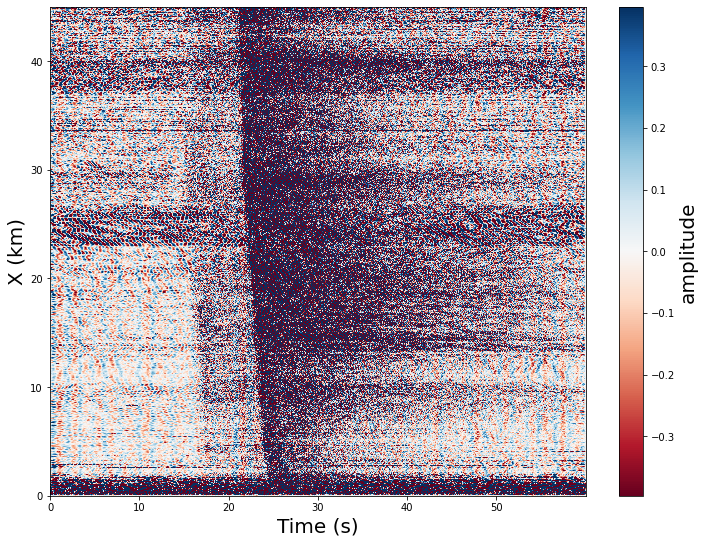

In [7]:
### visualize example data
time_data = filtered_data_norm[5]
max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])

plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sampling_rate, 250/sampling_rate).astype(int))
plt.yticks(np.arange(0, chan_max, 1000), (np.arange(0, dchan*chan_max, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

# 3. Load U-net models trained in different ways

In [8]:
""" Initialize the U-net model """
devc = try_gpu(i=0)

# U-net trained on pure raw (scaled) data (input and output)
model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[0,1,2,3])
model_1.to(devc)
model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.3.pt'))  # raw2raw
model_1.eval() 

# U-net trained on raw input data and FK filtered output data
model_2 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_2 = nn.DataParallel(model_2, device_ids=[0,1,2,3])
model_2.to(devc)
model_2.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_fk2fk.pt'))  # fk2fk
model_2.eval() 

# U-net trained on raw data input and FK-filtered data ouput.
model_3 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_3 = nn.DataParallel(model_3, device_ids=[0,1,2,3])
model_3.to(devc)
model_3.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2fk.pt'))  # raw2fk
model_3.eval() 

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Prepare data to be denoised

The data input is 1500 points, 1500 channels. For deploying this denoiser, enter the entire image (not masked).

In [9]:
### convert to torch tensors
X = filtered_data_norm[:100,np.newaxis,500:2000,:].astype(np.float32)
X = torch.from_numpy(X).to(devc)
print(X.shape)

torch.Size([100, 1, 1500, 1500])


Deploy denoise

In [29]:
### denoise - deploy
with torch.no_grad():
    ### raw2raw
    oneDenoise_1 = model_1(X)
    mulDenoise_1 = model_1(oneDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)

    ### fk2fk
    oneDenoise_2 = model_2(X)
    mulDenoise_2 = model_2(oneDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)

    ### raw2fk
    oneDenoise_3 = model_3(X)
    mulDenoise_3 = model_3(oneDenoise_3)

### convert back to numpy, trim edges
wid_edge = 125
rawdata = X.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
oneDenoise_1 = oneDenoise_1.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
oneDenoise_2 = oneDenoise_2.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
oneDenoise_3 = oneDenoise_3.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
mulDenoise_1 = mulDenoise_1.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
mulDenoise_2 = mulDenoise_2.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]
mulDenoise_3 = mulDenoise_3.to('cpu').numpy()#[:,:,:,wid_edge:-wid_edge]


In [30]:
oneDenoise_1.shape

(100, 1, 1500, 1500)

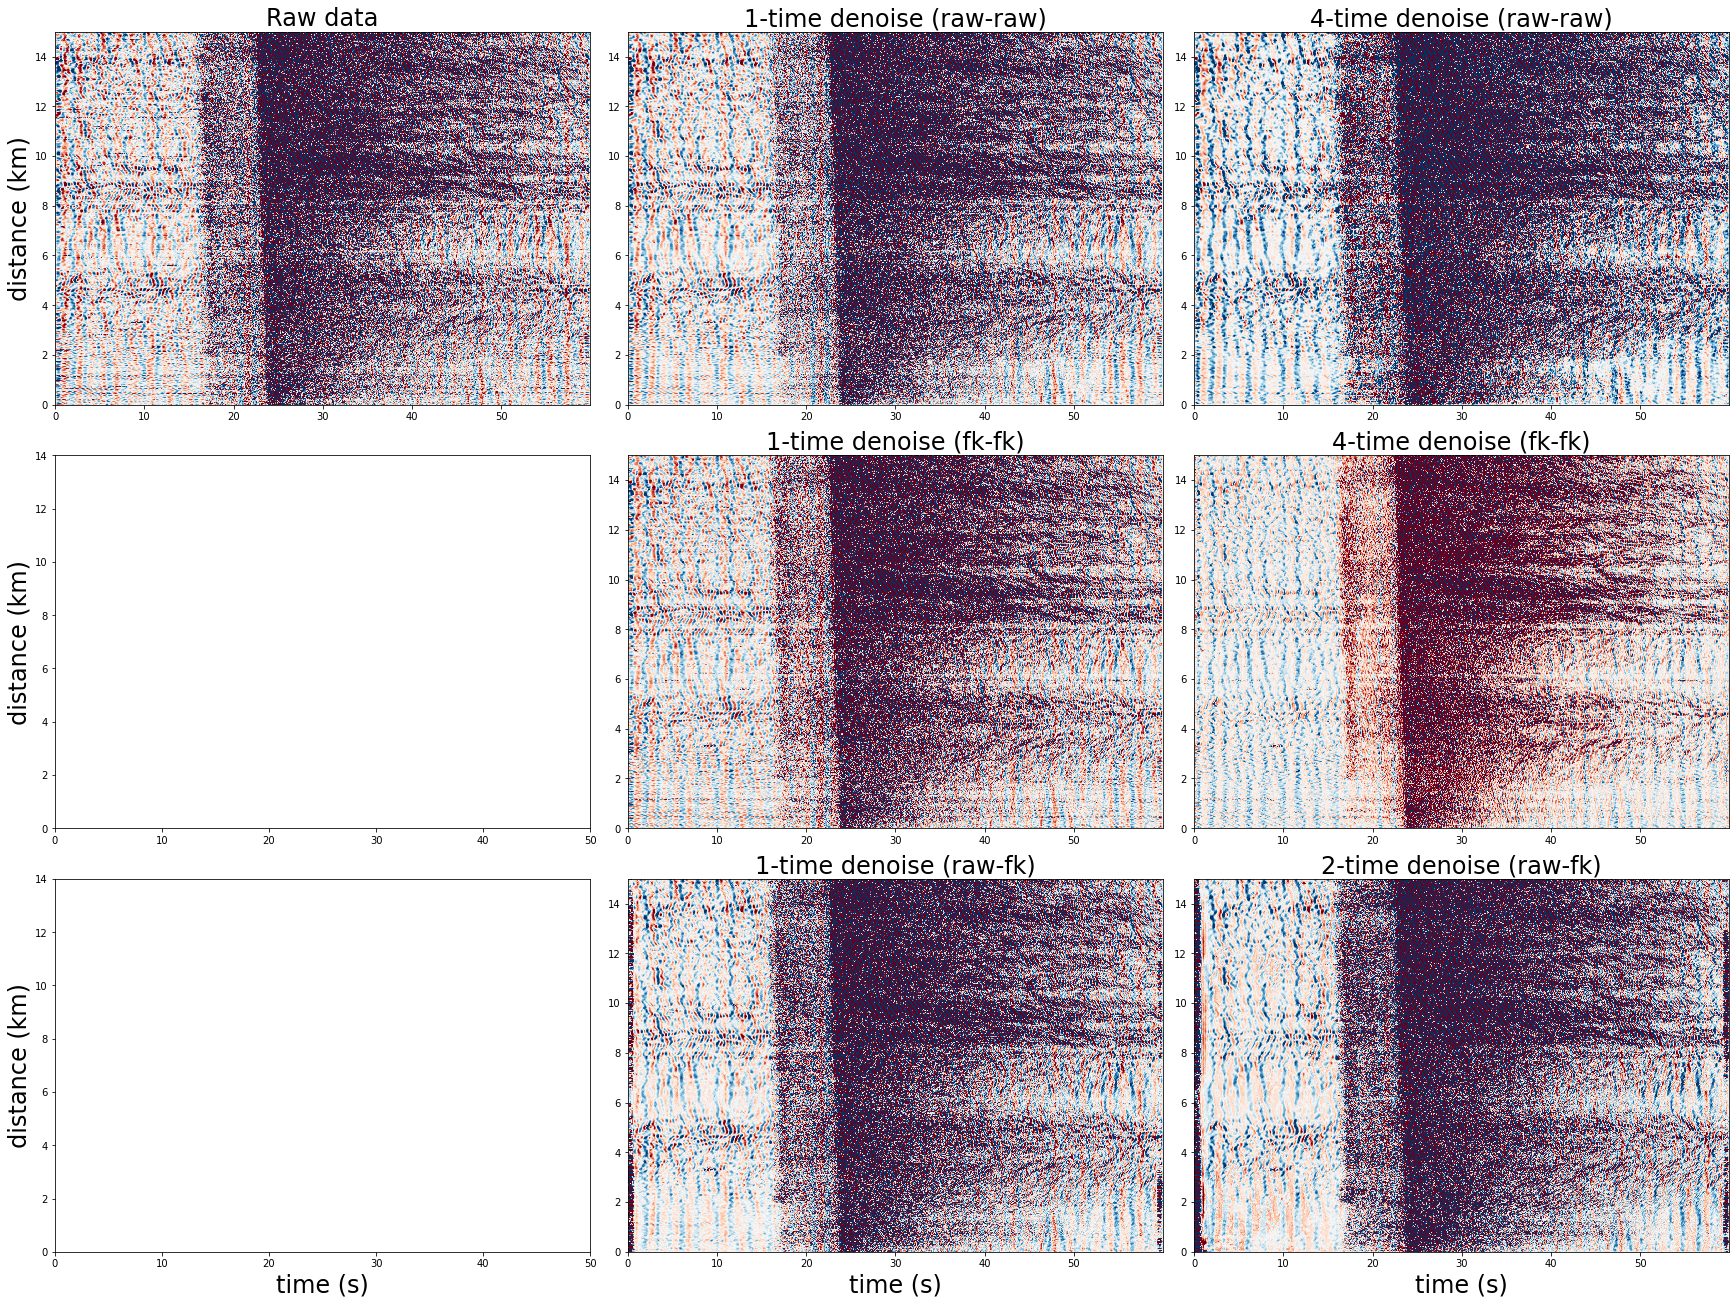

In [31]:
# visualize example data
for ind in np.arange(5,6):

    max_amp = np.median(np.fabs(rawdata[ind,0]))*2
    x, y = np.arange(rawdata[ind,0].shape[1]), np.arange(rawdata[ind,0].shape[0])
    fig, ax = plt.subplots(3, 3, figsize=(24, 18), constrained_layout=True)

    ax[0,1].pcolormesh(x, y, oneDenoise_1[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[0,1].set_title("1-time denoise (raw-raw)", fontsize=24)

    ax[1,1].pcolormesh(x, y, oneDenoise_2[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[1,1].set_title("1-time denoise (fk-fk)", fontsize=24)

    ax[2,1].pcolormesh(x, y, oneDenoise_3[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[2,1].set_title("1-time denoise (raw-fk)", fontsize=24)

    ax[0,2].pcolormesh(x, y, mulDenoise_1[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[0,2].set_title("4-time denoise (raw-raw)", fontsize=24)

    ax[1,2].pcolormesh(x, y, mulDenoise_2[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[1,2].set_title("4-time denoise (fk-fk)", fontsize=24)

    ax[2,2].pcolormesh(x, y, mulDenoise_3[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[2,2].set_title("2-time denoise (raw-fk)", fontsize=24)

    ax[0,0].pcolormesh(x, y, rawdata[ind,0], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
#     plt.colorbar(img, ax=ax[0,0])
    ax[0,0].set_title("Raw data", fontsize=24)

    for i in range(3):
        ax[2,i].set_xlabel('time (s)', fontsize=24)
        ax[i,0].set_ylabel('distance (km)', fontsize=24)
        for j in range(3):
            ax[i,j].set_xticks(np.arange(0, 1500, 250)) 
            ax[i,j].set_xticklabels(np.arange(0, 1500/sampling_rate, 250/sampling_rate).astype(int))
            ax[i,j].set_yticks(np.arange(0, 1500, 200))
            ax[i,j].set_yticklabels((np.arange(0, dchan*1500, 200*dchan)/1000).astype(int))
            
plt.show()


## Time to pick!

In [32]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05
fqmin = 0.1
fqmax = 5

dt = 0.001; fs = 100
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

In [33]:
# download models
pretrain_list = ["ethz","instance","scedc","stead","geofon","neic"]
# pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

In [34]:
pn_ethz_model.to(devc);
pn_scedc_model.to(devc);
pn_neic_model.to(devc);
pn_geofon_model.to(devc);
pn_stead_model.to(devc);
pn_instance_model.to(devc);

Resample the data to 100Hz.

In [35]:
from scipy.interpolate import interp1d

# interpolate the raw data
interpolation_function = interp1d(np.linspace(0, 1, 1500), filtered_data_norm[:100,500:2000,:], axis=2, kind='linear')
interpolated_image = interpolation_function(np.linspace(0, 1, 6000)
                                           )
# interpolate the denoised data.
interpolation_function = interp1d(np.linspace(0, 1, 1500), oneDenoise_3[:100,500:2000,:], axis=2, kind='linear')
interpolated_denoised = interpolation_function(np.linspace(0, 1, 6000))

In [36]:
interpolated_image.shape

(100, 1500, 6000)